# __Desafío - Mecanismos de Votación__
`by Benjamín Meneses`

## Requerimientos
Para esta actividad desarrollaremos un ensamble heterogéneo que prediga la popularidad o
impopularidad de contenido en línea de un sitio web. El archivo csv tiene un total de 39797
registros, donde cada uno representa características del artículo publicado en el sitio web.
Cada registro tiene un total de 61 atributos que miden características del texto, cantidad de
imágenes, keywords, etc. Los artículos provienen de la publicación K. Fernandes, P. Vinagre
and P. Cortez. A Proactive Intelligent Decision Support System for Predicting the Popularity
of Online News. Proceedings of the 17th EPIA 2015 - Portuguese Conference on Artificial
Intelligence, September, Coimbra, Portugal.. Los artículos registrados son de la [página web](https://mashable.com/).

Más información sobre los atributos se puede encontrar en el archivo
`OnlineNewsPopularity.names`.


In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import re
import helpers as hlp
df = pd.read_csv('OnlineNewsPopularity/OnlineNewsPopularity.csv')

## Ejercicio 1 - Preparación del Ambiente de Trabajo
- A continuación se le presenta un código que agrupa las variables por grupos. Cada
uno de éstos hace referencia a alguna característica de los registros en la base de
datos. Genere una análisis descriptivo de cada uno de los atributos. Puede utilizar la
función `grid_plot_batch` que se encuentra en el archivo `helpers.py`.
```python
# las etiquetas de las columnas presentan un espacio extra, con asto lo podemos eliminar
df.columns = [i.replace(' ', '') for i in df.columns]
# eliminamos el string de url que no sirve para el análisis
df = df.loc[:, 'n_tokens_title':'shares']
# generamos el conjunto de variables
qnty = df.filter(regex='^n_', axis=1)
channel = df.filter(regex='^data_', axis=1)
days = df.filter(regex=re.compile("weekday|weekend"), axis=1)
sentiments = df.filter(regex=re.compile("negative|positive|subjectivity"), axis=1)
lda = df.filter(regex='^LDA_\d', axis=1)
keywords = df.filter(regex='^kw_', axis=1)
```

- Describa el comportamiento de las variables.
- Dada la naturaleza de los atributos, es probable que algunas mediciones estén
correlacionadas entre sí. Para ello, genere un diagnóstico previo de multicolinealidad
utilizando la función `identify_high_correlations` que se encuentra en el archivo
`helpers.py`. Para todos aquellos atributos que tengan una correlación de .8, reporte
sus nombres.
- Antes de generar los conjuntos de entrenamiento y validación, pre procese los datos
con los siguientes pasos:
  - Recodifique la variable `shares` en una variable binaria que identifique como 1
todos los registros con más de 1400 "compartir" y 0 de lo contrario. Para
evitar multicolinealidad, elimine la variable shares posteriormente.
  - Elimine todas las variables que presentaban una correlación mayor a .8. Este
paso es para evitar la multicolinealidad de los atributos.
  - Genere un análisis de Componentes Principales para extraer las principales
30 dimensiones. Guarde estas dimensiones en un nuevo objeto.


In [71]:
# las etiquetas de las columnas presentan un espacio extra, con asto lo podemos eliminar
df.columns = [i.replace(' ', '') for i in df.columns]
# eliminamos el string de url que no sirve para el análisis
df = df.loc[:, 'n_tokens_title':'shares']
# generamos el conjunto de variables
qnty = df.filter(regex='^n_', axis=1)
channel = df.filter(regex='^data_', axis=1)
days = df.filter(regex=re.compile("weekday|weekend"), axis=1)
sentiments = df.filter(regex=re.compile("negative|positive|subjectivity"), axis=1)
lda = df.filter(regex='^LDA_\d', axis=1)
keywords = df.filter(regex='^kw_', axis=1)

In [72]:
# Se trae la función de helpers.py y se mejora
def grid_plot_batch(df, cols, figsize=(15, 8)):

    """
    grid_plot_batch: Genera una grilla matplotlib para cada conjunto de variables.

    Parámetros de ingreso:
        - df: un objeto pd.DataFrame
        - cols: cantidad de columnas en la grilla.
        - plot_type: tipo de gráfico a generar. Puede ser una instrucción genérica de matplotlib o seaborn.

    Retorno:
        - Una grilla generada con plt.subplots y las instrucciones dentro de cada celda.

    """
    # calcular un aproximado a la cantidad de filas
    rows = np.ceil(df.shape[1] / cols)
    fig, ax = plt.subplots(int(rows), cols, figsize=figsize)
    axes = ax.flatten()
    # para cada columna
    for index, (colname, serie) in enumerate(df.iteritems()):
        axes[index].set_title(colname)
        axes[index].hist(serie)
    plt.tight_layout()

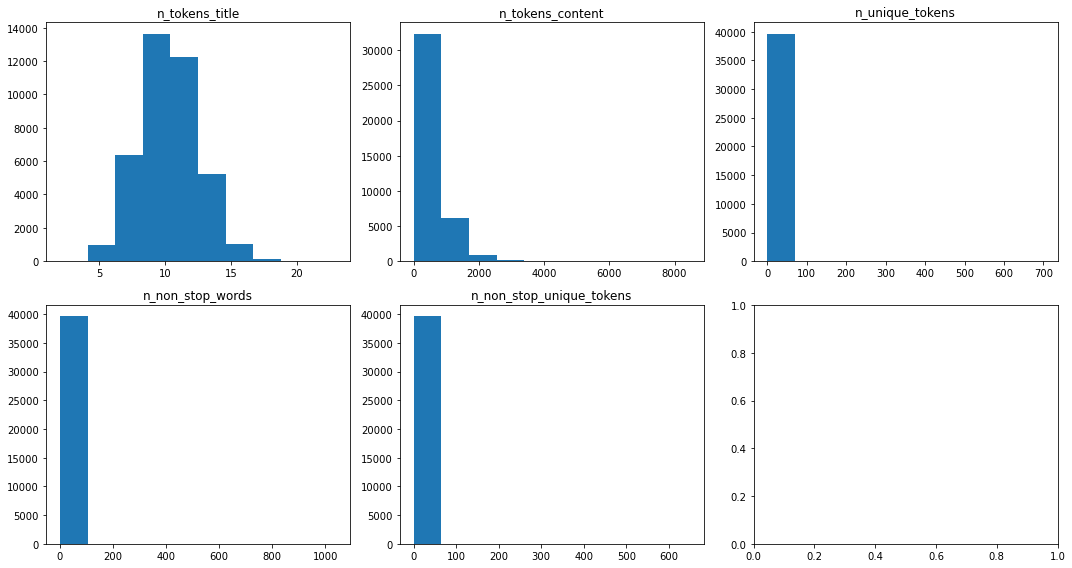

In [73]:
grid_plot_batch(qnty, 3)

Vemos que los valores para `n_non_stop_words`, `n_non_stop_unique_tokens` y `n_unique_tokens` tienen siempre valores menores a 100. `n_tokens_content` tiene una distribución mas alta llegando a valores > 1000. Finalmente `n_tokens_title` asemeja a una distibución gaussiana con media de 10.

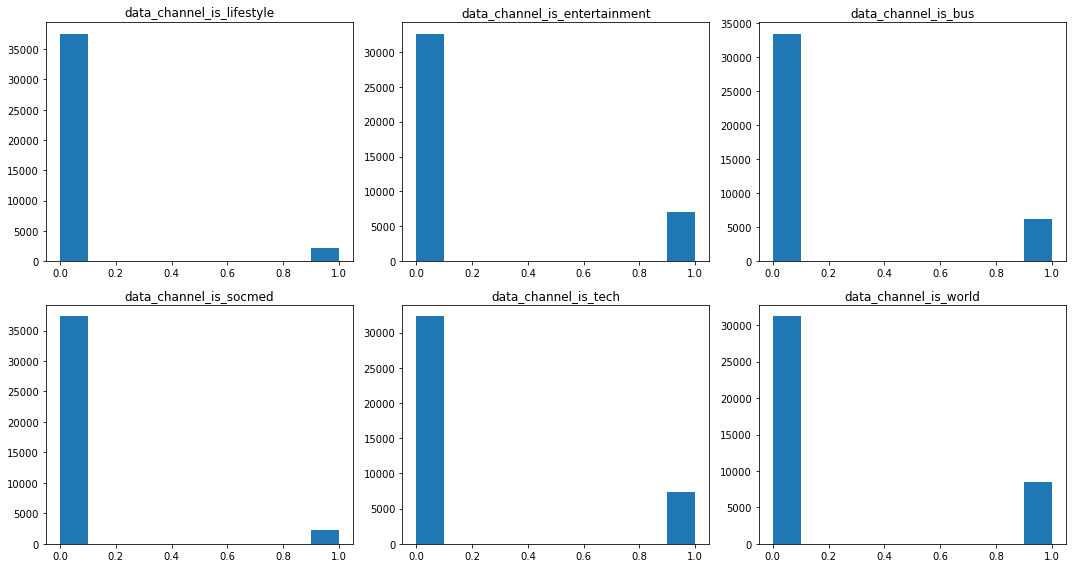

In [74]:
grid_plot_batch(channel, 3)

Vemos que son sólo variables binarias teniendo una distribución impareja entre ellas siendo `data_channel_is_world` la columna con mas valores 1 y `data_channel_is_socmed` y `data_channel_is_lifestyle` la con menos.

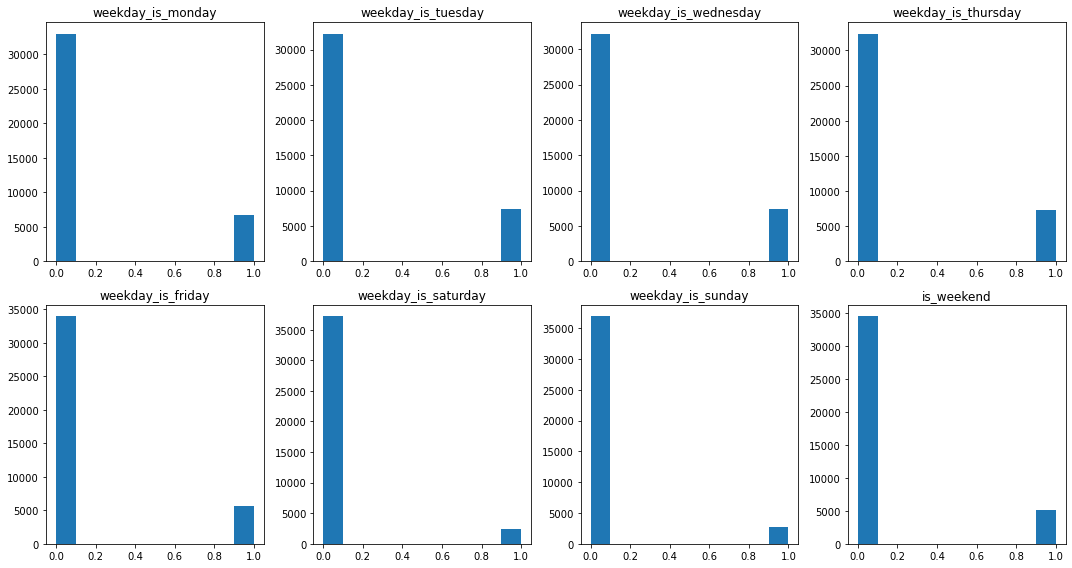

In [75]:
grid_plot_batch(days, 4)

Al igual que el set anterior, se presentan variables binarias desequilibradas entre ellas, siendo `weekday_is_saturday` y `weekday_is_sunday` las columnas con menos observaciones en 1

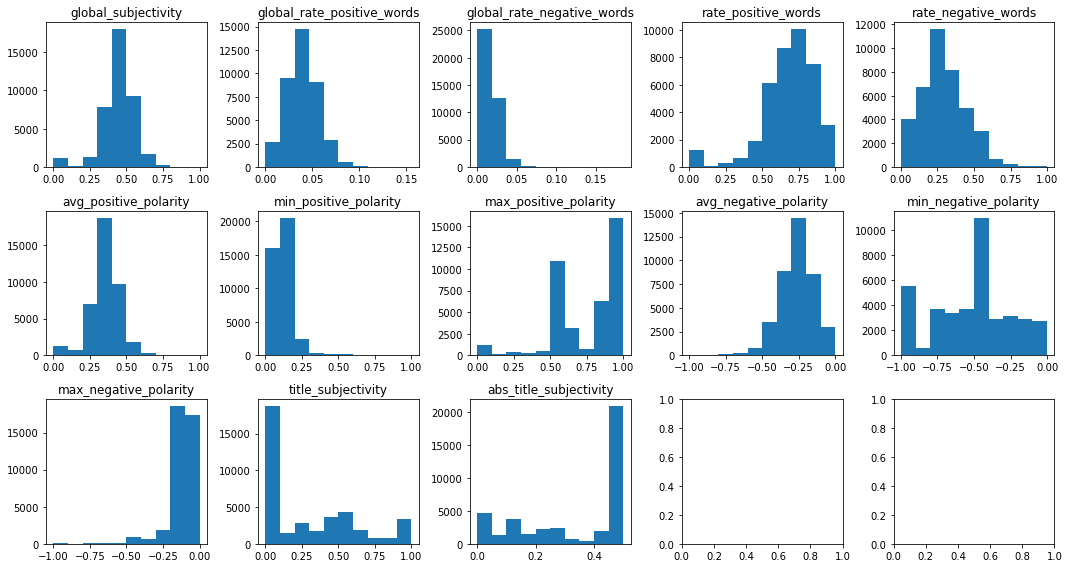

In [76]:
grid_plot_batch(sentiments, 5)

En este caso podemos observar que varios atributos presentan una distribución cercana a una Gaussiana, mientras que otras como `abs_title_subjectivity` sube exponencialmente y `title_subjectivity` es inversamente exponencial

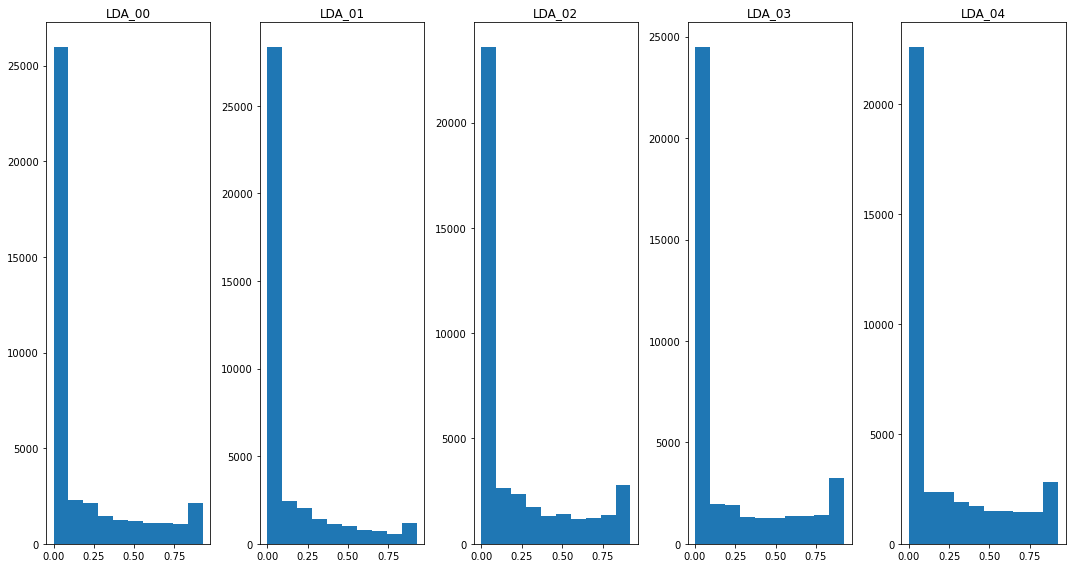

In [77]:
grid_plot_batch(lda, 5)

Vemos que todos los rangos son muy parecidos en su distribución. La única que escapa un poco es `LDA_01`

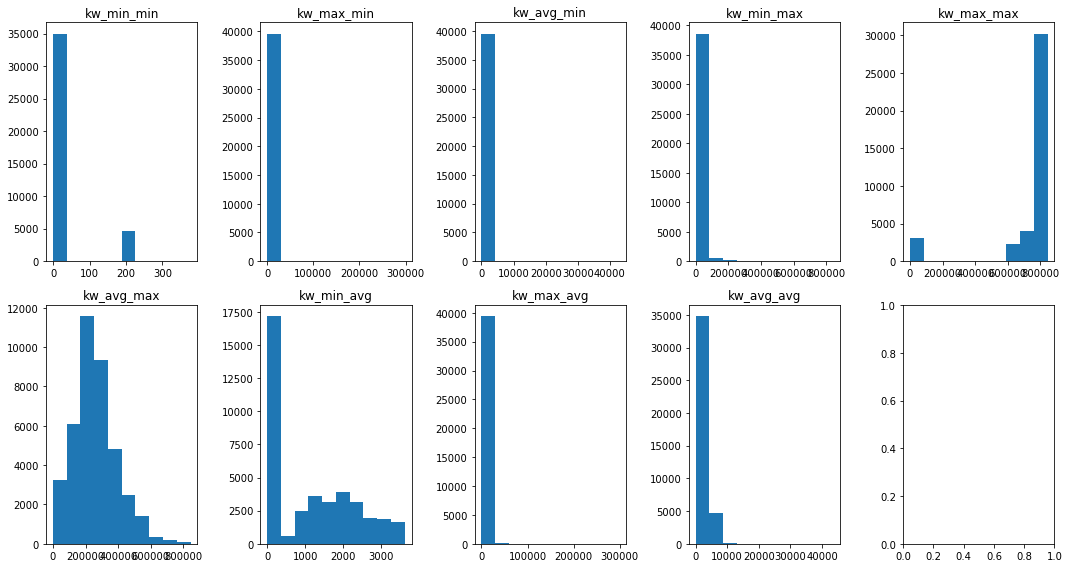

In [78]:
grid_plot_batch(keywords, 5)

Vemos que casi todas presentan valores extremos, sean muy bajos o muy altos. Con la excepción de `kw_avg_max` que presenta una distribución gaussiana y `kw_min_avg` con una gran cantidad de observaciones con valores bajos pero luego estabilizandose dentro de un rango cercano pasado el valor 1000.

Pasamos a analizar la correlación

In [79]:
# Traemos la función desde la lectura de helpers.py
def identify_high_correlations(df, threshold=.7):
    """
    identify_high_correlations: Genera un reporte sobre las correlaciones existentes entre variables, condicional a un nivel arbitrario.

    Parámetros de ingreso:
        - df: un objeto pd.DataFrame, por lo general es la base de datos a trabajar.
        - threshold: Nivel de correlaciones a considerar como altas. Por defecto es .7.

    Retorno:
        - Un pd.DataFrame con los nombres de las variables y sus correlaciones
    """

    # extraemos la matriz de correlación con una máscara booleana
    tmp = df.corr().mask(abs(df.corr()) < threshold, df)
    # convertimos a long format
    tmp = pd.melt(tmp)
    # agregamos una columna extra que nos facilitará los cruces entre variables
    tmp['var2'] = list(df.columns) * len(df.columns)
    # reordenamos
    tmp = tmp[['variable', 'var2', 'value']].dropna()
    # eliminamos valores duplicados
    tmp = tmp[tmp['value'].duplicated()]
    # eliminamos variables con valores de 1 
    return tmp[tmp['value'] < 1.00]

In [80]:
highCorr = identify_high_correlations(df, threshold=.8)
highCorr

,variable,var2,value
179,n_non_stop_words,n_unique_tokens,0.999572
238,n_non_stop_unique_tokens,n_unique_tokens,0.999852
239,n_non_stop_unique_tokens,n_non_stop_words,0.999532
1139,kw_avg_min,kw_max_min,0.940529
1256,kw_max_max,kw_min_min,-0.857226
1499,kw_avg_avg,kw_max_avg,0.811864
1678,self_reference_avg_sharess,self_reference_min_shares,0.818907
1679,self_reference_avg_sharess,self_reference_max_shares,0.853480
2317,LDA_02,data_channel_is_world,0.836618


Notamos que hay 9 combinaciones de variables que presentant una correlación absoluta > .8 Siendo todas de proporcionalidad directa menos `kw_max_max` y `kw_min_min`, lo cual tiene bastante sentido ya que respresentan los valores inversos.

In [81]:
# se recodifica la variable binaria de shares
df['shares'] = np.where(df['shares'] > 1000, 1, 0)
# Se eliminan las columnas que presentan alta correlación.
df = df.drop(columns=np.unique(highCorr['variable']))

In [85]:
# Se ejecuta el análisis de componentes con PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=30)
pca.fit(df)
# Se guarda el análisis de componentes con PCA
pca_df = pd.DataFrame(pca.components_, columns=df.columns)
pca_depurated = pca_df.applymap(lambda x: np.where(x < .4 and x > -.4, ' ', round(x, 2)))

,n_tokens_title,n_tokens_content,n_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,,,,,,,,,,,...,,,,,,,,,,
1,,,,,,,,,,,...,,,,,,,,,,
2,,,,,,,,,,,...,,,,,,,,,,
3,,,,,,,,,,,...,,,,,,,,,,
4,,,,,,,,,,,...,,,,,,,,,,
5,,,,,,,,,,,...,,,,,,,,,,
6,,,,,,,,,,,...,,,,,,,,,,
7,,1.0,,,,,,,,,...,,,,,,,,,,
8,,,,,,,,,,,...,,,,,,,,,,
9,,,,0.94,,,,,,,...,,,,,,,,,,


## Ejercicio 2 - Evaluación de modelos individuales
- A continuación generará una serie de modelos que se incorporarán posteriormente
al comité de votación. Para ello, se solicita que:
  - Importe los módulos correctamente.
  - Para cada uno de ellos, genere un reporte en las métricas de desempeño
respecto a `Precision`, `Recall`, `F1`. Puede hacer uso de la función
`plot_classification_report` disponible en el archivo `helpers.py`.
  - Comente el desempeño general de cada uno.
- La lista de modelos es la siguiente. Cabe destacar que la mayoría de éstos
corresponden a implementaciones vanilla, salvo que se indique lo contrario:
  - Regresión Logística.
  - Algoritmo de KMedias.
  - Árbol de Clasificación con un `max_depth=1`.
  - Árbol de Clasificación con un `max_depth=4`

In [86]:
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier

# se genera el conjunto de entrenamiento de datos
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['shares']), df['shares'], test_size=0.33, random_state=19137)

In [92]:
# se generan los modelos pedidos
logreg = LogisticRegression()
kmeans = KMeans(n_clusters=2)
treeStump = DecisionTreeClassifier(max_depth=1)
tree = DecisionTreeClassifier(max_depth=4)

# Se entrenan los modelos pedidos
logreg.fit(X_train, y_train)
kmeans.fit(X_train)
treeStump.fit(X_train, y_train)
tree.fit(X_train, y_train);

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DecisionTreeClassifier(max_depth=4)

In [102]:
# Se reportan las métricas usando classification report
print('LogisticRegression')
print(classification_report(y_test, logreg.predict(X_test)))

LogisticRegression
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4192
           1       0.68      1.00      0.81      8891

    accuracy                           0.68     13083
   macro avg       0.34      0.50      0.40     13083
weighted avg       0.46      0.68      0.55     13083



D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Vemos que el modelo de regresión logístca no presenta ninguna predicción de valores '0', mientras que sólo alcanza un F1 de .81 para las predicciones de "1"

In [95]:
print('KMeans')
print(classification_report(y_test, kmeans.predict(X_test)))

KMeans
              precision    recall  f1-score   support

           0       0.33      0.67      0.44      4192
           1       0.69      0.35      0.47      8891

    accuracy                           0.45     13083
   macro avg       0.51      0.51      0.45     13083
weighted avg       0.58      0.45      0.46     13083



Vemos que en sí el modelo de KMeans presenta un desempeño peor que una muestra de elección aleatoria. De todos modos se entiende que el modelo no es un algoritmo supervisado, por lo que evaluarlo usando `classification_report` es un tanto injusto, ya que no hay una relación entre los grupos conseguidos por KMeans y el vector objetivo.

In [96]:
print('DecisionTreeClassifier max_depth=1')
print(classification_report(y_test, treeStump.predict(X_test)))

DecisionTreeClassifier max_depth=1
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4192
           1       0.68      1.00      0.81      8891

    accuracy                           0.68     13083
   macro avg       0.34      0.50      0.40     13083
weighted avg       0.46      0.68      0.55     13083



D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Vemos que nuevamente el stump generado no genera predicciones de la clase '0' por loq ue genera un desmpeño bastante malo en esos indicadores, de todos modos podemos observar que para la clase '1' este se comporta de igual manera que la regresión logistica.

In [97]:
print('DecisionTreeClassifier max_depth=4')
print(classification_report(y_test, tree.predict(X_test)))

DecisionTreeClassifier max_depth=4
              precision    recall  f1-score   support

           0       0.56      0.30      0.39      4192
           1       0.73      0.89      0.80      8891

    accuracy                           0.70     13083
   macro avg       0.64      0.59      0.60     13083
weighted avg       0.67      0.70      0.67     13083



Vemos que este modelo es el que tiene mejores métricas de entre los 3 anteriores. Presentando un accuracy cercano a .7, y al menos generando un f1 de .39 para la clase '0'

## Ejercicio 3 - Entrenamiento de Comité
- Entrene el comité de clasificadores sin modificar el esquema de votación.
- Reporte el desempeño a nivel de cada clase para cada métrica.



In [103]:
# Se entrena el modelo usando un VotingClassifier
voting = VotingClassifier(estimators=[('logreg', logreg), ('kmeans', kmeans), ('treeStump', treeStump), ('tree', tree)], voting='hard')
voting.fit(X_train, y_train)


ValueError: The estimator KMeans should be a classifier.

Vemos que KMeans no es considerado un clasificador apto para el ensamble, por lo que lo eliminaremos de este.

In [104]:
# Se genera el ensamble.
voting = VotingClassifier(estimators=[('logreg', logreg), ('treeStump', treeStump), ('tree', tree)])
voting.fit(X_train, y_train)
# Se evalúa el ensamble.
print('VotingClassifier')
print(classification_report(y_test, voting.predict(X_test)))

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4192
           1       0.68      1.00      0.81      8891

    accuracy                           0.68     13083
   macro avg       0.34      0.50      0.40     13083
weighted avg       0.46      0.68      0.55     13083



D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Vemos que el ensamble no generó ninguna predicción para la clase '0' lo que hace que se tenga un 0 en todas las métricas. Del mismo modo las métricas para la clase "1" son iguales a las de el stump y la regresión logística obtenidas en el ejercicio anterior.

## Ejercicio 4 - Calibración de Comité con Ponderadores
- En base al comportamiento de los clasificadores individuales del ensamble,
proponga dos esquemas de ponderación para mejorar el desempeño del modelo.
- Reporte el desempeño del mejor ensamble heterogéneo.

In [107]:
# implemetamos una ponderación que acentúe el modelo de árbol en dos intensidades distintas
treePonderation = [0.25, 0.25, 0.5]
treeMaxPonderation = [.125, .125, .75]

# Se genera el ensamble con el ponderador 1:1:2.
voting = VotingClassifier(estimators=[('logreg', logreg), ('treeStump', treeStump), ('tree', tree)], weights=treePonderation)
voting.fit(X_train, y_train)
# Se evalúa el ensamble.
print('VotingClassifier')
print(classification_report(y_test, voting.predict(X_test)))
# Se genera el ensamble con el ponderador 1:1:6.
votingMax = VotingClassifier(estimators=[('logreg', logreg), ('treeStump', treeStump), ('tree', tree)], weights=treeMaxPonderation)
votingMax.fit(X_train, y_train)
# Se evalúa el ensamble.
print('VotingClassifier')
print(classification_report(y_test, votingMax.predict(X_test)))

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier
              precision    recall  f1-score   support

           0       0.56      0.30      0.39      4192
           1       0.73      0.89      0.80      8891

    accuracy                           0.70     13083
   macro avg       0.64      0.59      0.60     13083
weighted avg       0.67      0.70      0.67     13083



D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier
              precision    recall  f1-score   support

           0       0.56      0.30      0.39      4192
           1       0.73      0.89      0.80      8891

    accuracy                           0.70     13083
   macro avg       0.64      0.59      0.60     13083
weighted avg       0.67      0.70      0.67     13083



Vemos que al aumentar el ponderador del estimador de arbol max_depth=4 el ensamble termina teniendo las mismas métricas que este por sí sólo